In [90]:
import pandas as pd
from torchvision import transforms
import torchvision
import torchsummary
import numpy as np
from code.diganes_dataset import DiganesDataset
from code.MyPytorchModel import MyPytorchModel
from code.transformations import RandomPermutation, ReverseTransform
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from PIL import Image
import pickle
from sklearn.metrics import classification_report

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load dataset and checkout transformation

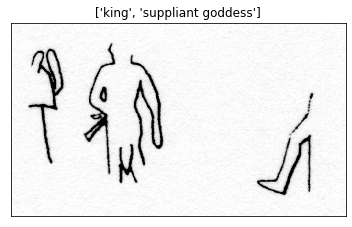

In [91]:
label_file = '/Users/atad/Desktop/DIGANES/diganes/diganens.csv'
pic_dir = '/Users/atad/Desktop/DIGANES/pics'
diganes = DiganesDataset(label_file, pic_dir, category='drawing', min_label_count=50)

image, labels = diganes[222]
diganes.show_image(image, labels)

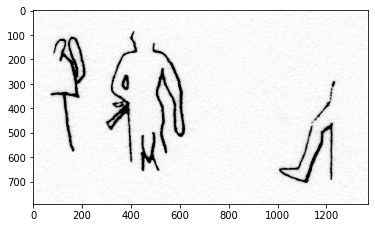

In [92]:
transform = RandomPermutation(cache_dir=pic_dir)
per = transform(image)
plt.imshow(per)

In [93]:
transform = transforms.Compose(
    [RandomPermutation(cache_dir=pic_dir),
     transforms.Resize((224, 224)),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(), 
     transforms.Normalize(mean=[0.49191375, 0.48235852, 0.44673872], 
                          std=[0.24706447, 0.24346213, 0.26147554])])

reverse_transform = ReverseTransform(mean=[0.49191375, 0.48235852, 0.44673872],
                                     std=[0.24706447, 0.24346213, 0.26147554])

dataset = DiganesDataset(label_file, pic_dir, category='drawing', min_label_count=50, 
                         transform=transform, reverse_transform=reverse_transform)

In [94]:
# load the pretrained model
pretrained_model = torchvision.models.mobilenet_v2(pretrained=True)

# features
print('Conv feature extractor:')
print(pretrained_model.features)
# classifier
print('Classification head:')
print(pretrained_model.classifier)

Conv feature extractor:
Sequential(
  (0): ConvBNReLU(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Re

In [95]:
feature_extractor = pretrained_model.features

torchsummary.summary(feature_extractor, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [96]:
# Feel free to change the hyperparameters here!
hparams = {
    "batch_size": 64,
    "lr": 3e-4
}

#set seed so split to datasets is reproducible
torch.manual_seed(32)
model = MyPytorchModel(hparams, dataset, torchvision.models.mobilenet_v2(pretrained=True))

NameError: name 'init_weights' is not defined

In [97]:
trainer = None

early_stop_callback = EarlyStopping(
   monitor='val_f1',
   patience=3,
   verbose=True,
   mode='max'
)

trainer = pl.Trainer(
    max_epochs=10,
    early_stop_callback=early_stop_callback
)

trainer.fit(model)

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.
/Users/atad/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
/Users/atad/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `test_dataloader()` and have defined a `test_step()`, you may also want to define `test_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)

    | Name                                | Type                 | Params
-------------------------------------------------------------------------
0   | model                               | PretrainedClassifier | 2 M   
1   | model.feature_extractor             | Sequential           | 

/Users/atad/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-F1=0.13


/Users/atad/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-F1=0.10


Val-F1=0.17


Detected KeyboardInterrupt, attempting graceful shutdown...


1

In [24]:
f_score, scores, labels = model.getDataloaderF1()
print("F-1 Score: ", f_score)

F-1 Score:  0.7204988985146868


In [25]:
print("Classification report: \n", (classification_report(labels, scores, zero_division=0)))

Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.78      0.88       122
           1       0.90      0.38      0.54        50
           2       0.82      0.43      0.57        53
           3       0.90      0.55      0.68        51
           4       0.95      0.91      0.93       128
           5       0.98      0.91      0.94       122
           6       1.00      0.38      0.55        72
           7       0.94      0.29      0.45        51
           8       1.00      0.10      0.17        42
           9       0.95      0.88      0.91       190
          10       0.98      0.78      0.87       244
          11       0.94      0.37      0.53        84
          12       1.00      0.95      0.97       238
          13       0.99      0.97      0.98       676
          14       1.00      0.22      0.36        59
          15       0.94      0.96      0.95       347
          16       0.95      0.85      0.90        81
  

/Users/atad/Desktop/DIGANES/diganes/code/diganes_dataset.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


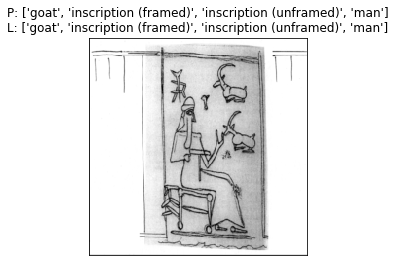

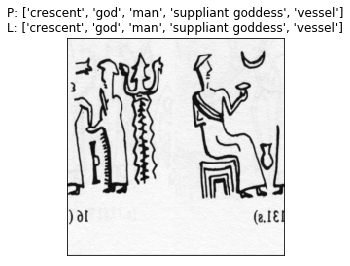

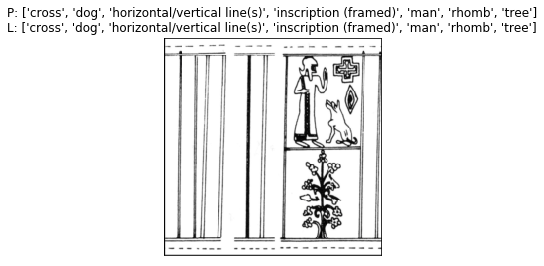

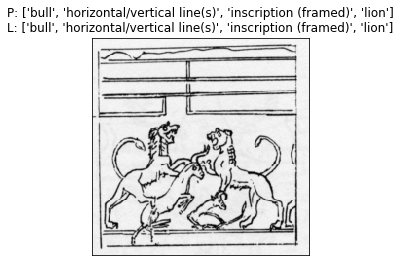

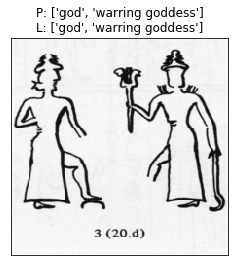

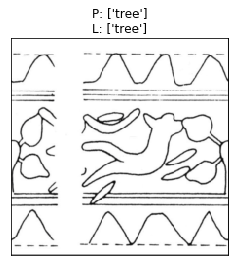

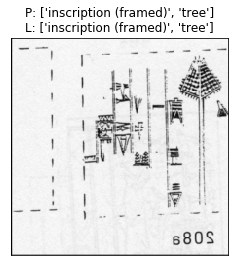

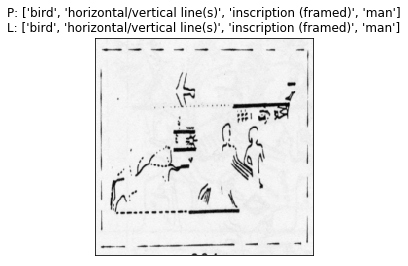

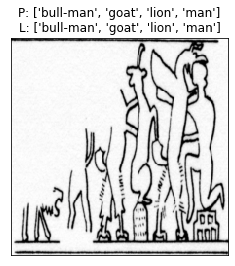

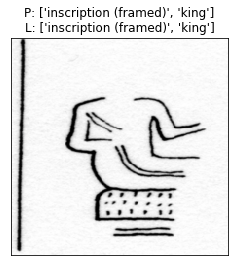

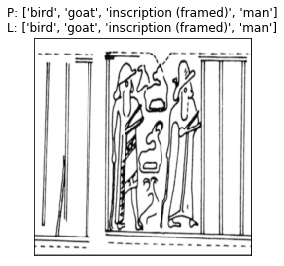

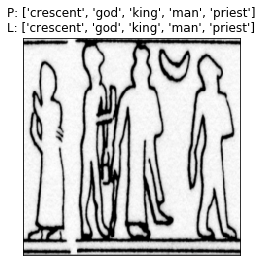

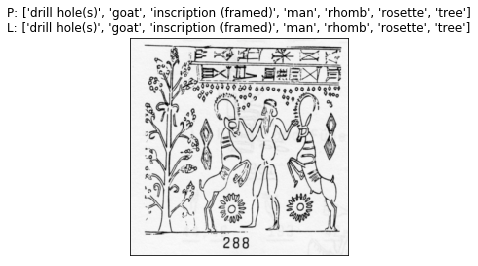

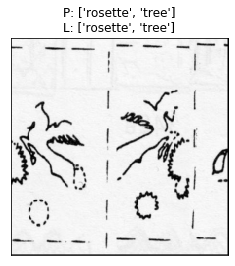

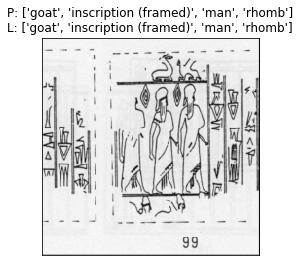

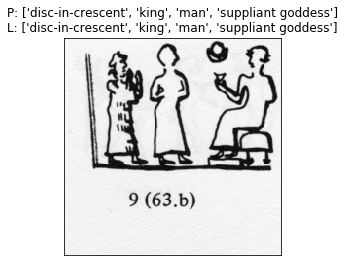

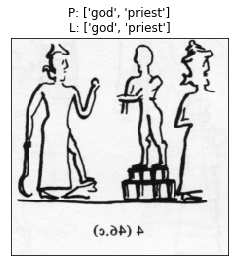

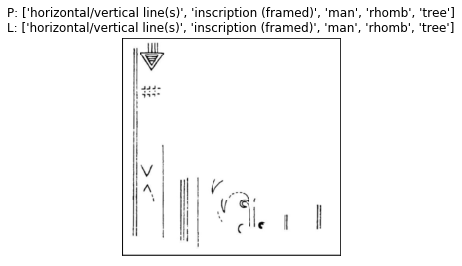

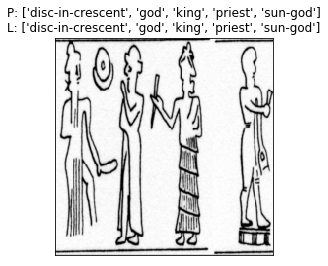

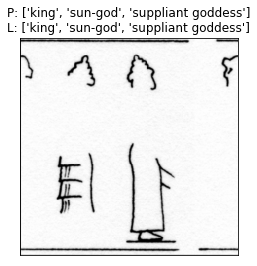

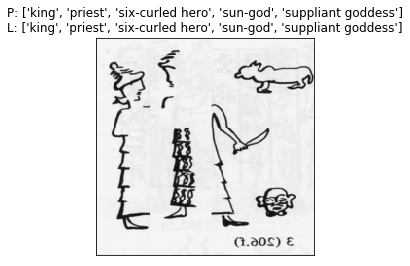

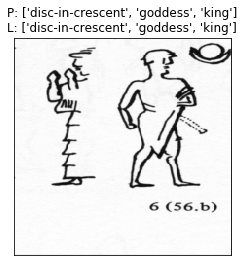

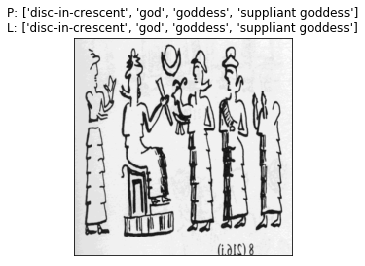

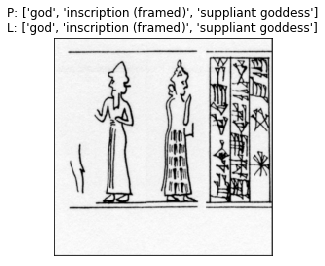

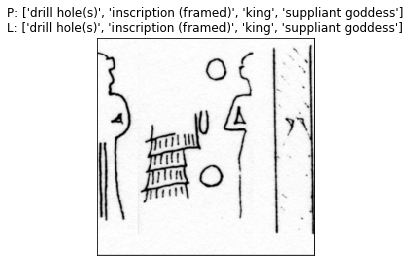

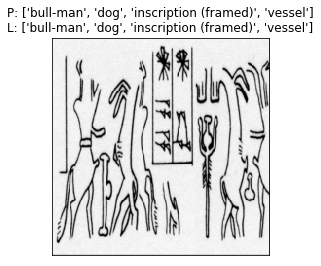

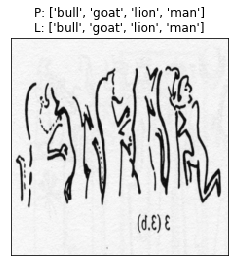

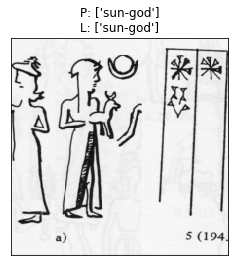

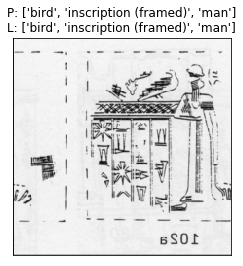

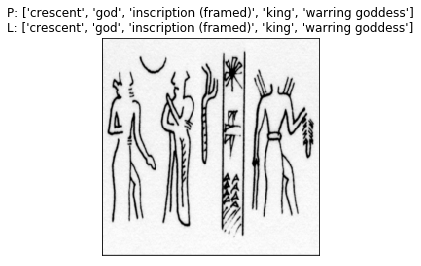

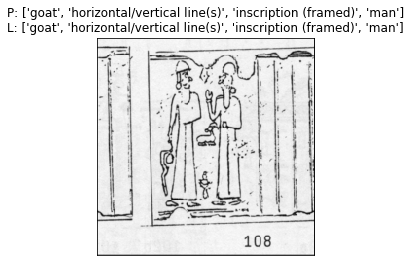

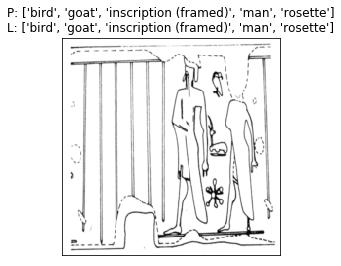

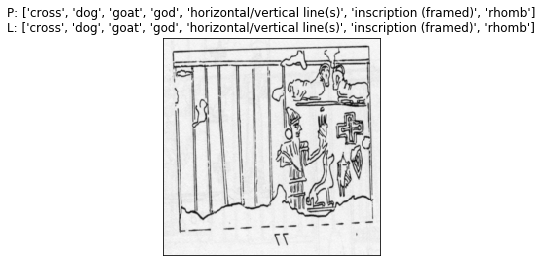

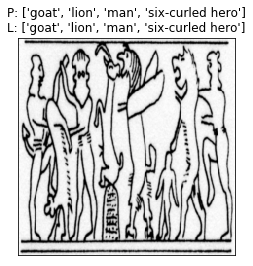

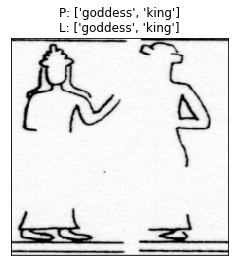

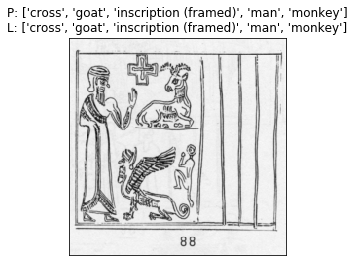

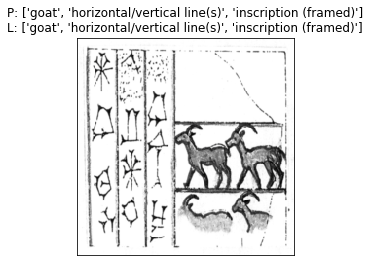

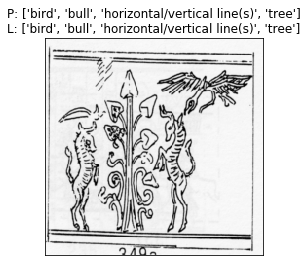

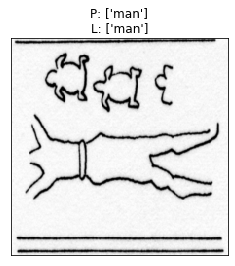

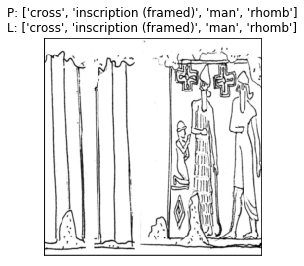

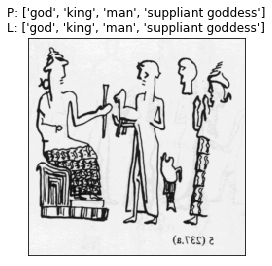

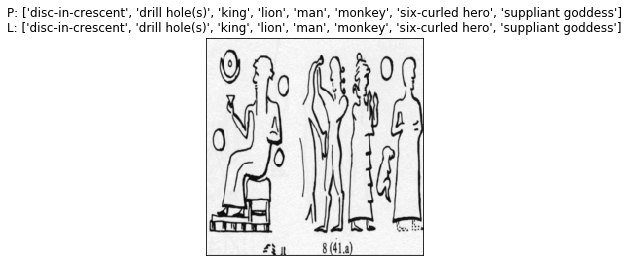

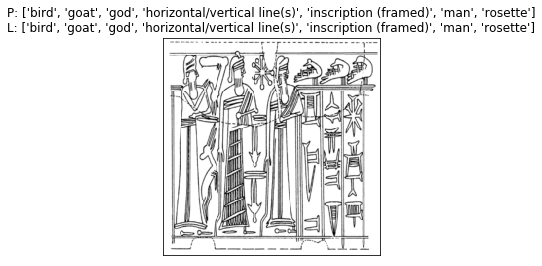

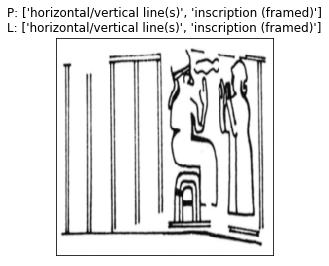

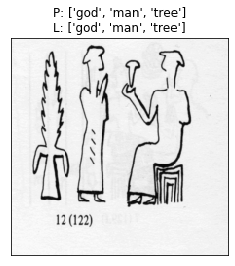

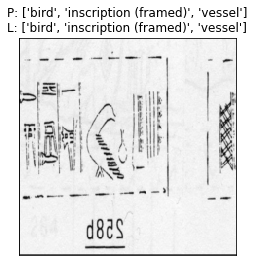

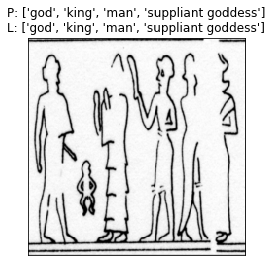

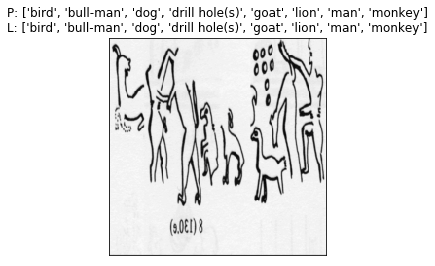

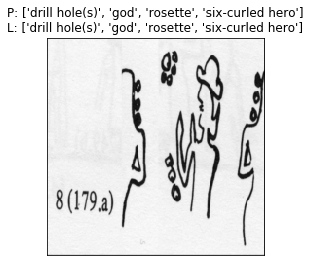

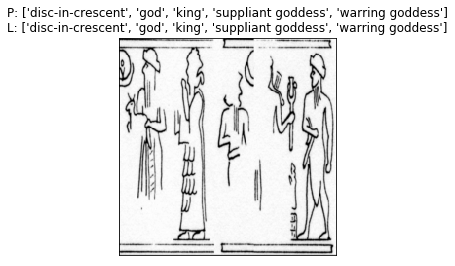

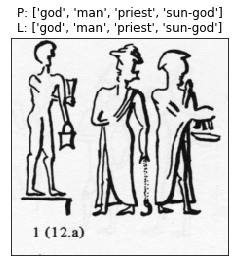

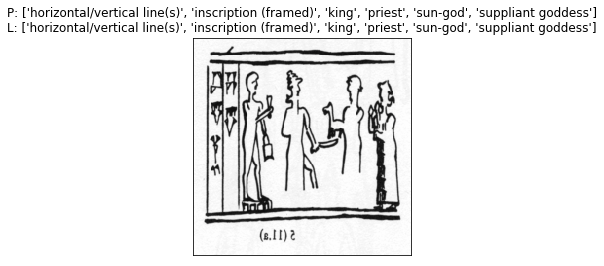

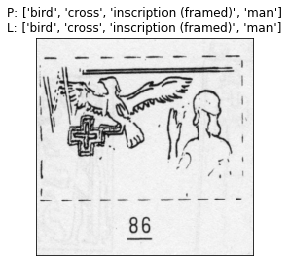

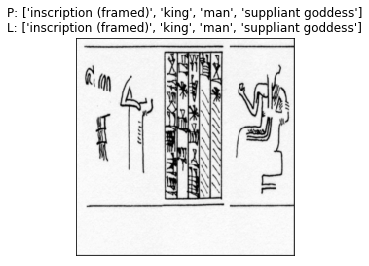

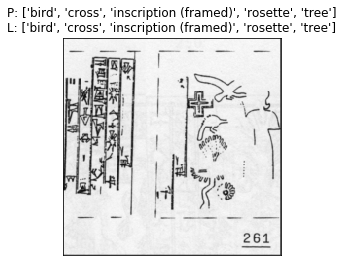

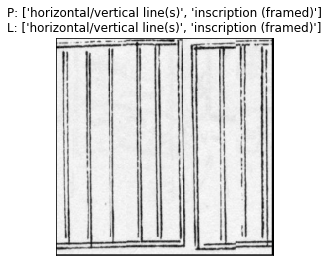

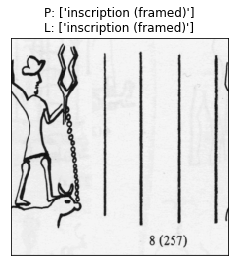

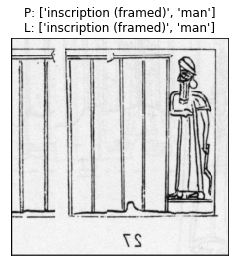

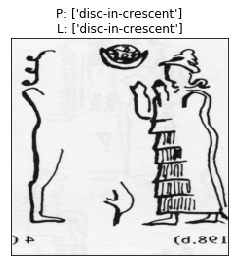

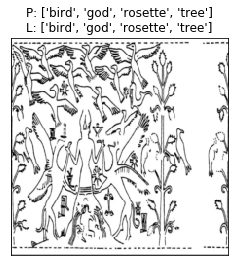

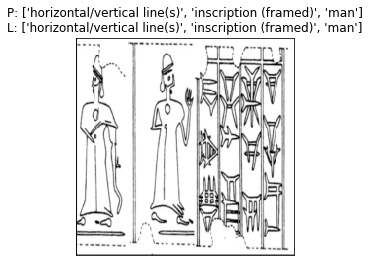

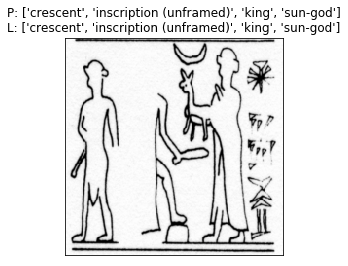

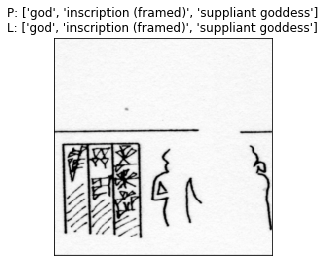

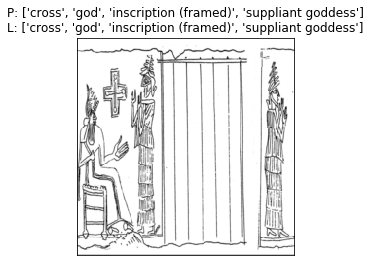

In [89]:
%matplotlib inline
model.model.eval()

for batch in model.val_dataloader():
    X, y = batch
    for i in range(X.shape[0]):
        image = X[i,:,:,:].squeeze()
        labels = y[i,:].squeeze()
        
        dataset.show_image(image, labels, labels)
    break


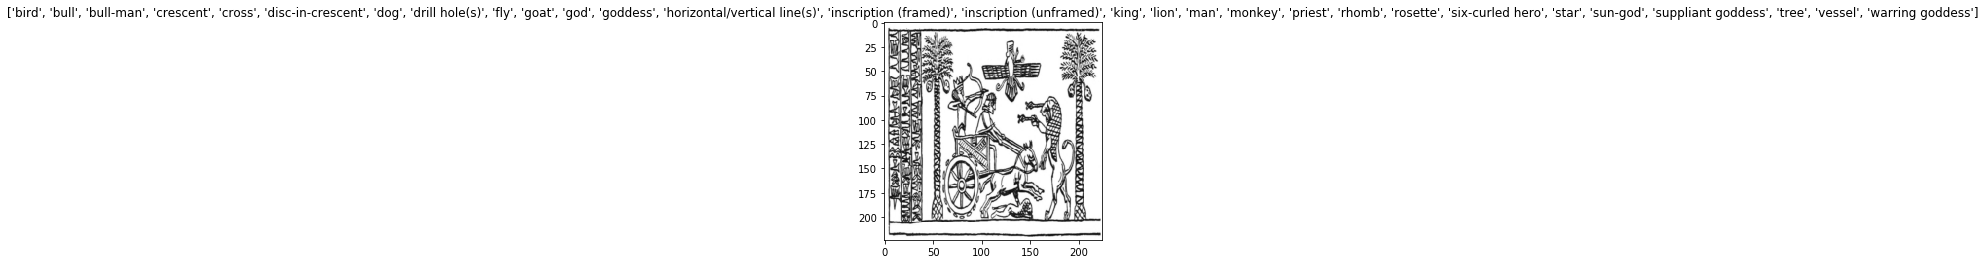

In [32]:
model.eval()
image = Image.open('test3.jpg')
image = transform(image)
X = image.reshape((1, 3, 224, 224))

score = model.forward(X)
preds = (torch.sigmoid(score).data > 0.5).float()
dataset.show_image(image, preds[0])

In [41]:
torch.save(model, "mobilenet_v2_model.pt")


TypeError: can't pickle _thread.lock objects